## Loading Rate Voltage Data

10.5.3: Quantifying the Number of Trapped Atoms (with Voltage data)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [7]:
# change file name
filename = r"C:\Users\Aditi\Physics111B\MOTdata\PD30_bigcirc.txt"

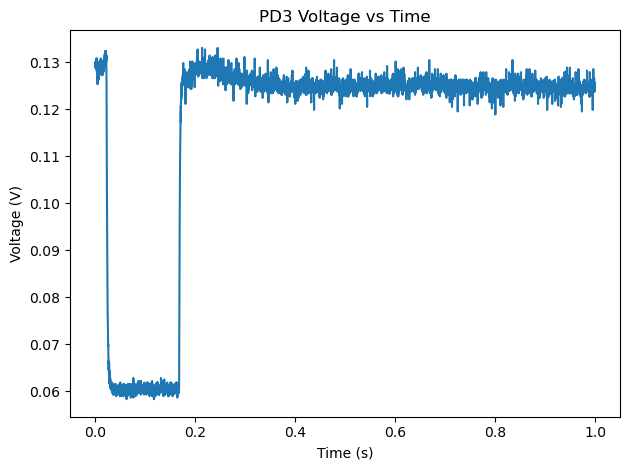

In [8]:
voltages = []
start_reading = False

with open(filename, "r") as f:
    for line in f:
        line = line.strip()

        # start reading after the Voltage header
        if line.startswith("Voltage"):
            start_reading = True
            continue

        if start_reading and line:
            voltages.append(float(line))

voltages = np.array(voltages)

# create time axis
fs = 10000  # Hz
t = np.arange(len(voltages)) / fs

plt.figure()
plt.plot(t, voltages)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("PD3 Voltage vs Time")
plt.tight_layout()
plt.show()


In [12]:
V_min = np.min(voltages)
print(f"Min room light: {V_min}")
V_room = np.mean(voltages[voltages <= 0.065])
print(f"Mean room light: {V_room}")

Min room light: 0.05828
Mean room light: 0.0604267347083926


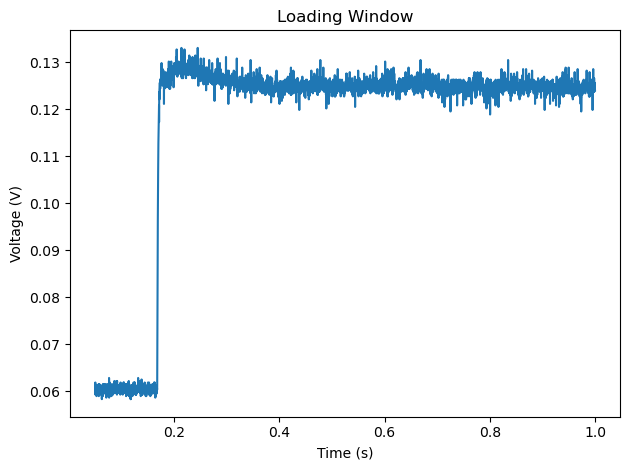

In [15]:
V_zoomed = voltages[500:]
t_zoomed = t[500:]
plt.figure()
plt.plot(t_zoomed, V_zoomed)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Loading Window")
plt.tight_layout()
plt.show()

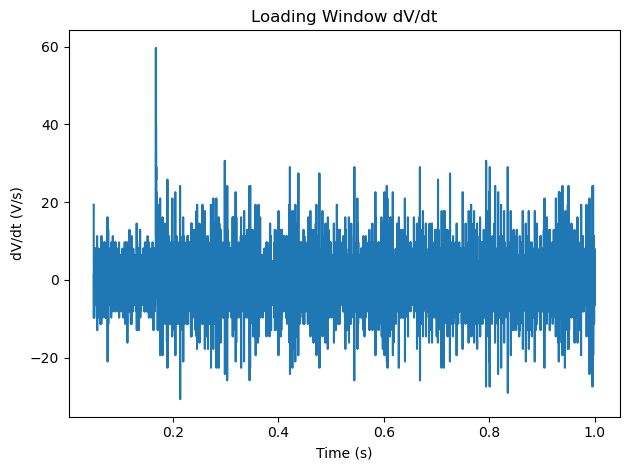

In [16]:
dVdt = np.gradient(V_zoomed, t_zoomed)

plt.figure()
plt.plot(t_zoomed, dVdt)
plt.xlabel("Time (s)")
plt.ylabel("dV/dt (V/s)")
plt.title("Loading Window dV/dt")
plt.tight_layout()
plt.show()


In [55]:
print(t_zoomed[6]-t_zoomed[0])

0.0005999999999999964


In [56]:
# Calculate turn on time
i0 = np.argmax(dVdt)
t0 = t_zoomed[i0]
print(t0)
i0_switch = i0+4


0.1678


Loading window length: 8318


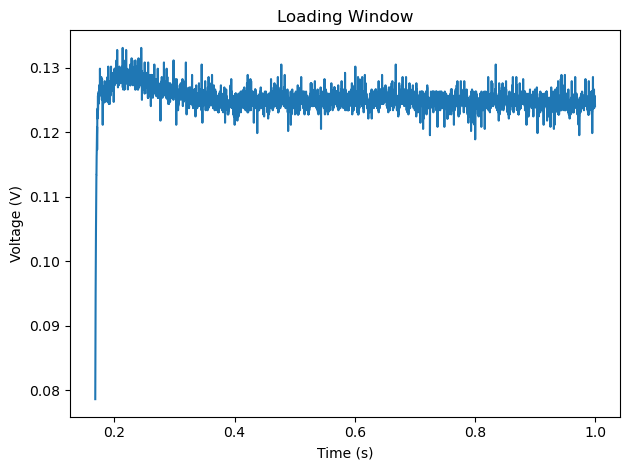

In [57]:
V_loading_window = V_zoomed[i0_switch:]
print(f"Loading window length: {len(V_loading_window)}")

t_loading_window = t_zoomed[i0_switch:]
plt.figure()
plt.plot(t_loading_window, V_loading_window)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Loading Window")
plt.tight_layout()
plt.show()

In [58]:
t_rel = t_loading_window - t_loading_window[0]

# Model: V(t) = Vbg + A*(1 - exp(-t/tau))
def loading_model(t, Vbg, A, tau):
    return Vbg + A * (1 - np.exp(-t / tau))

Vbg0 = np.mean(V_loading_window[:max(5, int(0.001 / np.median(np.diff(t_loading_window))))])  # ~first 1 ms
Vf0  = np.mean(V_loading_window[-max(5, int(0.002 / np.median(np.diff(t_loading_window)))):]) # ~last 2 ms
A0 = max(Vf0 - Vbg0, 1e-6)
tau0 = (t_rel[-1] - t_rel[0]) / 3 if t_rel[-1] > 0 else 0.002

p0 = [Vbg0, A0, tau0]
bounds = ([-np.inf, 0.0, 1e-9], [np.inf, np.inf, np.inf])  # enforce A>0, tau>0

popt, pcov = curve_fit(loading_model, t_rel, V_loading_window, p0=p0, bounds=bounds, maxfev=20000)
Vbg, A, tau = popt
Vf = Vbg + A
R_volts_per_s = A / tau

Vbg = 0.125211 ± 0.000046 V
A   = 0.000000 ± 0.000214 V
tau = 1.928815 ± 0.000000 s
Vf  = 0.125211 V
Loading rate (proportional) A/tau = 0.000000 V/s


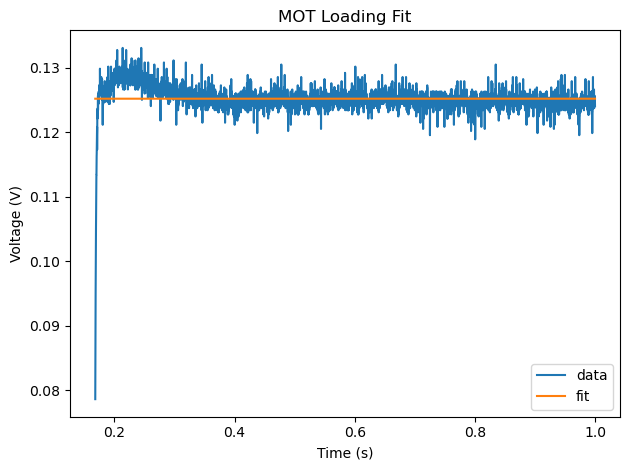

In [59]:
# 1-sigma uncertainties
perr = np.sqrt(np.diag(pcov))
Vbg_err, A_err, tau_err = perr

print(f"Vbg = {Vbg:.6f} ± {Vbg_err:.6f} V")
print(f"A   = {A:.6f} ± {A_err:.6f} V")
print(f"tau = {tau:.6f} ± {tau_err:.6f} s")
print(f"Vf  = {Vf:.6f} V")
print(f"Loading rate (proportional) A/tau = {R_volts_per_s:.6f} V/s")

# 5) Plot data + fit
plt.figure()
plt.plot(t_loading_window, V_loading_window, label="data")
plt.plot(t_loading_window, loading_model(t_rel, *popt), label="fit")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("MOT Loading Fit")
plt.legend()
plt.tight_layout()
plt.show()

### Fluorescence (Scattering) Rate per Atom

The rate at which a single atom scatters photons from the MOT light fields is

$$
R_{\text{sc}}=\frac{\Gamma}{2}\frac{s}{1+s+\left(\frac{2\Delta}{\Gamma}\right)^2}
$$

where $\Gamma$ is the natural linewidth, $\Delta$ is the laser detuning from resonance, and $s=I/I_{\text{sat}}$ is the saturation parameter.

For the Rb $D_2$ transition,
$$
\Gamma \approx 2\pi \times 6.07~\text{MHz}.
$$

We estimate the intensity at the atom cloud from the measured beam power $P$ and beam radius $w$ (Gaussian beam) as
$$
I \approx \frac{2P}{\pi w^2},
$$
and use $I_{\text{sat}} \approx 1.7~\text{mW/cm}^2$ for the cycling transition.

Beam diameter:
0.8 cm 
0.9 cm
0.92 cm
0.85 cm

Input Power:
- x: 5.426 mW
- y: 5.734 mW
- z: 9.26 mW



In [80]:
# --- Detuning ---
detuning_MHz = 138 

Delta_rad_s = detuning_MHz*1e6*2*np.pi

# --- Rb D2 linewidth ---
Gamma_rad_s = 2*np.pi*6.07e6   # rad/s

# --- Saturation intensity ---
I_sat = 17.0  # W/m^2  (1.7 mW/cm^2)

# --- Mean beam radius (meters) ---
omega_mean = np.mean([0.008/2, 0.009/2, 0.0092/2, 0.0085/2])  # meters

# intensity at MOT
def Ix_MOT(Px):
    Ix = 2*Px/(np.pi*omega_mean**2)
    return Ix

def scattering_rate(Px):
    I = Ix_MOT(Px)
    s = I / I_sat

    frac = s / (1 + s + (2*Delta_rad_s/Gamma_rad_s)**2)
    R_sc = (Gamma_rad_s/2) * frac

    print(f"Beam radius w = {omega_mean*1e3:.2f} mm")
    print(f"Total intensity = {I:.2f} W/m^2 = {I/10:.2f} mW/cm^2")
    print(f"Saturation parameter s = {s:.2f}")
    print(f"Scattering rate R_sc = {R_sc:.2e} s^-1")
    print(f"Maximum possible (Γ/2) = {Gamma_rad_s/2:.2e} s^-1")

    return R_sc

Px, Py, Pz = 0.005426, 0.005734, 0.00926  # W
R_sc = scattering_rate(Px)

Beam radius w = 4.34 mm
Total intensity = 183.60 W/m^2 = 18.36 mW/cm^2
Saturation parameter s = 10.80
Scattering rate R_sc = 9.91e+04 s^-1
Maximum possible (Γ/2) = 1.91e+07 s^-1


### Computing Solid Angle for PD3
- Distance from MOT to focusing lens: 14.5 mm
- Diameter of focusing lens: 5.5 mm

In [81]:
# ---- inputs (in mm) ----
d_mm = 14.5      # distance from MOT to focusing lens [mm]
D_mm = 5.5       # diameter of focusing lens [mm]

# ---- compute ----
a_mm = D_mm / 2.0
theta = np.arctan(a_mm / d_mm)                 # half-angle [rad]
Omega = 2*np.pi*(1 - np.cos(theta))            # solid angle in sr
eta = Omega / (4*np.pi)                        # fraction of isotropic emission

print(f"Lens radius a = {a_mm:.3f} mm")
print(f"Distance d    = {d_mm:.3f} mm")
print(f"Half-angle θ  = {np.degrees(theta):.3f} deg ({theta:.6f} rad)")
print(f"Solid angle Ω = {Omega:.6f} sr")
print(f"Collected fraction Ω/4π = {eta:.6%}")

Lens radius a = 2.750 mm
Distance d    = 14.500 mm
Half-angle θ  = 10.739 deg (0.187429 rad)
Solid angle Ω = 0.110040 sr
Collected fraction Ω/4π = 0.875674%


Photodetector Efficiency (A/W) @ 780 nm - DET100A ThorLabs: ~ 0.47 A/W

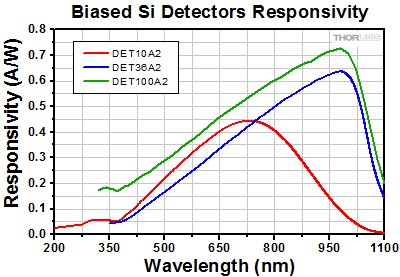 

PD3 Voltage Analong I/O Impedance: 1 MOhm

Mean saturation voltage: 0.10580632277375904 V


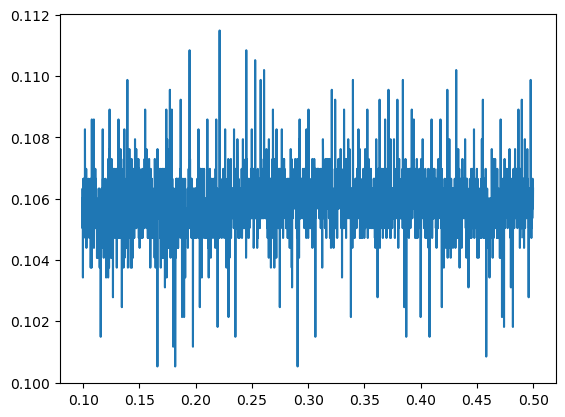

In [82]:
clip_index = 280
V_saturation_window = V_loading_window[clip_index:]
plt.plot(t_loading_window[clip_index:], V_loading_window[clip_index:], label="data")
sat_voltage = np.mean(V_loading_window[clip_index:])
print(f"Mean saturation voltage: {sat_voltage} V")

### Collection Efficiency of PD3:
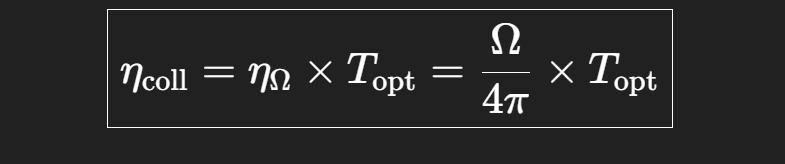

In [83]:
def pd3_VtoW(voltages,Vbg, impedance_ohm, responsivity_aw):
    return (voltages-Vbg) / (impedance_ohm*responsivity_aw)

def pd3_photon_detection_rate(powers, omega, T_opt=0.9):
    h = 6.626e-34
    c = 2.99e8
    lamb = 780e-9
    E_per_photon = h*c/lamb
    collection_efficiency = omega*T_opt/(4*np.pi)
    print(f"{collection_efficiency=}")
    return powers/E_per_photon

In [84]:
impedance_ohm = 1e6
responsivity_aw = 0.45
V_to_W = pd3_VtoW(V_saturation_window, Vbg, impedance_ohm,responsivity_aw)
print(f"Mean Power at Saturation: {np.mean(V_to_W)*1e6} uW")
photon_detection_rate = pd3_photon_detection_rate(V_to_W, Omega)
mean_detection_rate = np.mean(photon_detection_rate)
print(f"Mean Photon Detection Rate: {mean_detection_rate} photons/S")

Mean Power at Saturation: 0.013768344032013744 uW
collection_efficiency=0.007881064061869681
Mean Photon Detection Rate: 54206790241.39586 photons/S


Atom Number:
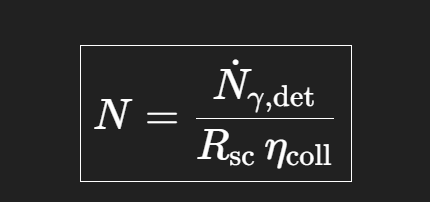
$R_sc$ = scattering rate
$N^dot^ = mean photon detection rate
$eta_col$ = collection efficiency of PD3

## Atom Number from MOT Fluorescence

The atom number $N$ in the MOT is related to the detected fluorescence by

$$
\dot{N}_{\gamma} = N \, R_{\mathrm{sc}} \, \eta_{\mathrm{coll}}
$$

Solving for the atom number gives

$$
\boxed{
N = \frac{\dot{N}_{\gamma}}{R_{\mathrm{sc}} \, \eta_{\mathrm{coll}}}
}
$$

where:

- $R_{\mathrm{sc}}$ is the photon scattering rate per atom (s$^{-1}$)
- $\dot{N}_{\gamma}$ is the mean detected photon rate (photons/s)
- $\eta_{\mathrm{coll}}$ is the collection efficiency of PD3

---

### Photon detection rate from measured power

If the detected optical power on the photodiode is $P_{\mathrm{PD}}$, then

$$
\dot{N}_{\gamma} = \frac{P_{\mathrm{PD}}}{h\nu}
$$

with

$$
h\nu = \frac{hc}{\lambda}
$$

where $\lambda \approx 780\ \mathrm{nm}$ for Rb D2 fluorescence.

---

### Final expression using measured power

$$
\boxed{
N = \frac{P_{\mathrm{PD}}}{h\nu \, R_{\mathrm{sc}} \, \eta_{\mathrm{coll}}}
}
$$


In [85]:
def atom_number(R_sc, detection_rate):
    a_numb = detection_rate/(R_sc)
    return np.mean(a_numb)

In [86]:
atom_numb = atom_number(R_sc, photon_detection_rate)
atom_numb

547262.386497116

In [66]:
atom_numb = atom_number(R_sc, photon_detection_rate)
atom_numb

1575635.0809188124

In [61]:
# detuning calibration
V_p2p_ch1 = 0.044 # V
linewidth = 3036e6
conv = V_p2p_ch1/linewidth
print(conv*1e6)                                                                                     

1.4492753623188405e-05


In [ ]:
loading_rate = R_volts_per_s
scatter_rate = 


In [57]:
3707-3700

7

In [58]:
(700e-6/conv)*1e-6

48.3

In [59]:
138e6/(6.07e6)

22.73476112026359